In [1]:
import numpy as np
import cntk_unet
import simulation
%matplotlib inline
import helper

import cntk as C
from cntk.learners import learning_rate_schedule, UnitType

(3, 1, 192, 192) (3, 6, 192, 192)


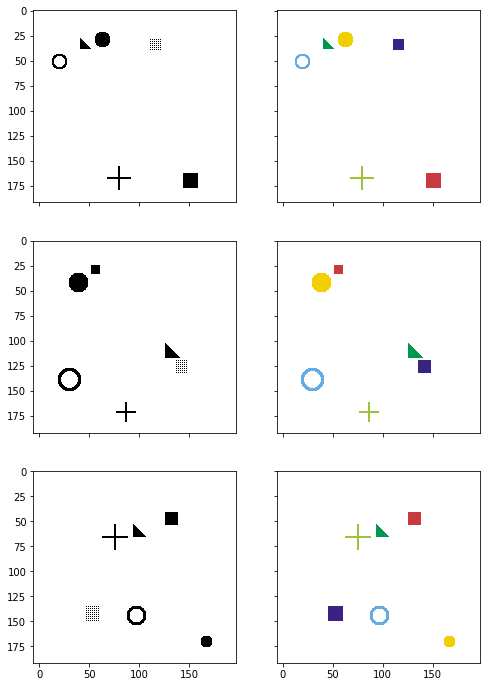

In [2]:
# Generate some random images
input_images, target_masks = simulation.generate_random_data(192, 192, count=3)

print(input_images.shape, target_masks.shape)

# Change channel-order and make 3 channels for matplot
input_images_rgb = [(x.swapaxes(0, 2).swapaxes(0,1).repeat(3, axis=2) * -255 + 255).astype(np.uint8) for x in input_images]

# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in target_masks]

# Left: Input image, Right: Target mask
helper.plot_side_by_side([input_images_rgb, target_masks_rgb])

In [3]:
from cntk.device import try_set_default_device, gpu
try_set_default_device(gpu(0))

def slice_minibatch(data_x, data_y, i, minibatch_size):
    sx = data_x[i * minibatch_size:(i + 1) * minibatch_size]
    sy = data_y[i * minibatch_size:(i + 1) * minibatch_size]
    
    return sx, sy

def measure_error(data_x, data_y, x, y, trainer, minibatch_size):
    errors = []
    for i in range(0, int(len(data_x) / minibatch_size)):
        data_sx, data_sy = slice_minibatch(data_x, data_y, i, minibatch_size)        

        errors.append(trainer.test_minibatch({x: data_sx, y: data_sy}))

    return np.mean(errors)

def train(images, masks, use_existing=False):  
    shape = input_images[0].shape
    data_size = input_images.shape[0]
    
    # Split data
    test_portion = int(data_size * 0.1)
    indices = np.random.permutation(data_size)
    test_indices = indices[:test_portion]
    training_indices = indices[test_portion:]

    test_data = (images[test_indices], masks[test_indices])
    training_data = (images[training_indices], masks[training_indices])

    # Create model
    x = C.input_variable(shape)
    y = C.input_variable(masks[0].shape)

    z = cntk_unet.create_model(x, masks.shape[1])
    dice_coef = cntk_unet.dice_coefficient(z, y)

    # Load the saved model if specified
    checkpoint_file = "cntk-unet.dnn"
    if use_existing:
        z.load_model(checkpoint_file)

    # Prepare model and trainer
    lr = learning_rate_schedule(0.00001, UnitType.sample)
    momentum = C.learners.momentum_as_time_constant_schedule(0.9)
    trainer = C.Trainer(z, (-dice_coef, -dice_coef), C.learners.adam(z.parameters, lr=lr, momentum=momentum))

    # Get minibatches of training data and perform model training
    minibatch_size = 8
    num_epochs = 75
    
    training_errors = []
    test_errors = []

    for e in range(0, num_epochs):
        for i in range(0, int(len(training_data[0]) / minibatch_size)):
            data_x, data_y = slice_minibatch(training_data[0], training_data[1], i, minibatch_size)

            trainer.train_minibatch({x: data_x, y: data_y})
        
        # Measure training error
        training_error = measure_error(training_data[0], training_data[1], x, y, trainer, minibatch_size)
        training_errors.append(training_error)
        
        # Measure test error
        test_error = measure_error(test_data[0], test_data[1], x, y, trainer, minibatch_size)
        test_errors.append(test_error)

        print("epoch #{}: training_error={}, test_error={}".format(e, training_errors[-1], test_errors[-1]))
        
        trainer.save_checkpoint(checkpoint_file)

    return trainer, training_errors, test_errors

In [4]:
input_images, target_masks = input_images, target_masks = simulation.generate_random_data(192, 192, count=1024)

trainer, training_errors, test_errors = train(input_images, target_masks)

epoch #0: training_error=-0.019768690868564275, test_error=-0.020717654066781204
epoch #1: training_error=-0.14359762888887653, test_error=-0.14444618796308836
epoch #2: training_error=-0.16253145324147267, test_error=-0.16211109856764475
epoch #3: training_error=-0.19506786180579144, test_error=-0.19313516840338707
epoch #4: training_error=-0.22743441371814063, test_error=-0.2299772041539351
epoch #5: training_error=-0.22651763014171433, test_error=-0.2276181268195311
epoch #6: training_error=-0.25330155660276826, test_error=-0.2570686799784501
epoch #7: training_error=-0.27093734209952147, test_error=-0.2745807444055875
epoch #8: training_error=-0.32097409859947534, test_error=-0.3199269076188405
epoch #9: training_error=-0.32212045840595077, test_error=-0.3231043294072151
epoch #10: training_error=-0.4180802334909854, test_error=-0.41908330221970874
epoch #11: training_error=-0.5081395947414896, test_error=-0.5119023198882738
epoch #12: training_error=-0.5355584644753, test_error=-0

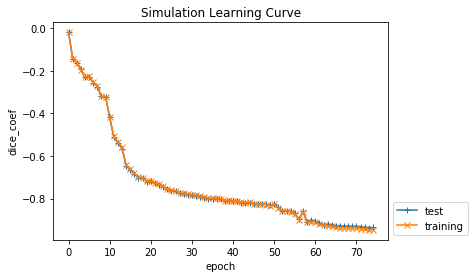

In [8]:
helper.plot_errors({"training": training_errors, "test": test_errors}, title="Simulation Learning Curve")

In [9]:
# Generate some random images
input_images, target_masks = input_images, target_masks = simulation.generate_random_data(192, 192, count=10)

# Predict
pred = trainer.model.eval(input_images)

print(input_images.shape, target_masks.shape, pred.shape)

(10, 1, 192, 192) (10, 6, 192, 192) (10, 6, 192, 192)


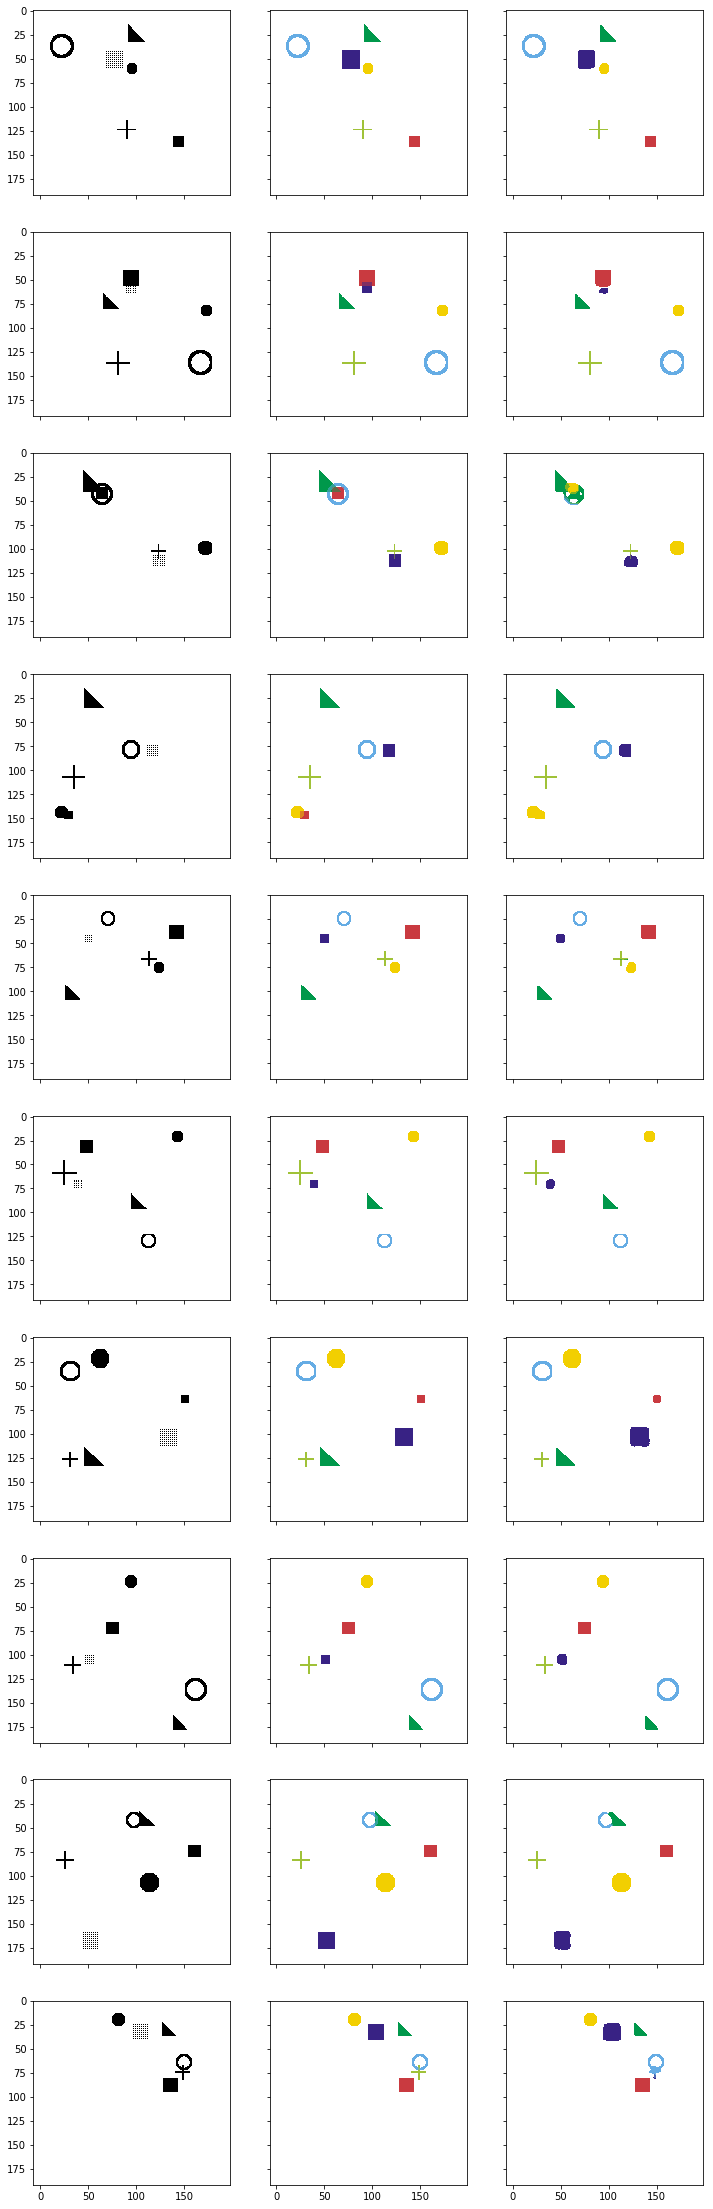

In [10]:
# Change channel-order and make 3 channels for matplot
input_images_rgb = [(x.swapaxes(0, 2).swapaxes(0,1).repeat(3, axis=2) * -255 + 255).astype(np.uint8) for x in input_images]

# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in target_masks]
pred_rgb = [helper.masks_to_colorimg(x) for x in pred]

# Left: Input image, Middle: Correct mask (Ground-truth), Rigth: Predicted mask
helper.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])